## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
import numpy as np
import torch
import whisper
import datasets

import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.eval_dataset_name_to_dataset_group import EVAL_DATASET_NAME_TO_DATASET_GROUP

device = torch.device('mps')
sns.set_theme(context="paper", style="ticks")

/opt/homebrew/Caskroom/miniforge/base/envs/mlmi-dissertation-new/lib/python3.10/site-packages/whisper/timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):


In [4]:
# Load the Whisper model
model = whisper.load_model("tiny")

In [5]:
dataset_name = "librispeech_dummy"

ds_group = EVAL_DATASET_NAME_TO_DATASET_GROUP[dataset_name]()

if dataset_name == "librispeech_dummy":
    ds = ds_group.str2dataset["librispeech_dummy"]
    ds = ds.map(lambda x: {"text": x.lower()}, input_columns=["text"])
elif dataset_name in ["ami", "ami_10h"]:
    ds = ds_group.str2dataset["ami"]
    ds = ds.map(lambda x: {"text": x.lower()}, input_columns=["text"])
else:
    raise ValueError()

Found cached dataset librispeech_asr_dummy (/Users/Tony/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)
Loading cached processed dataset at /Users/Tony/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b/cache-b8597f65be34771e.arrow


In [6]:
sample = next(iter(ds))

sample

{'file': '/Users/Tony/.cache/huggingface/datasets/downloads/extracted/ebb1d3f740add5af71e53b628d8c9c55e64fc2ff14a6ff31de01228adc704d35/dev_clean/1272/128104/1272-128104-0000.flac',
 'audio': {'path': '/Users/Tony/.cache/huggingface/datasets/downloads/extracted/ebb1d3f740add5af71e53b628d8c9c55e64fc2ff14a6ff31de01228adc704d35/dev_clean/1272/128104/1272-128104-0000.flac',
  'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
         0.0010376 ]),
  'sampling_rate': 16000},
 'text': 'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel',
 'speaker_id': 1272,
 'chapter_id': 128104,
 'id': '1272-128104-0000'}

In [7]:
sample["audio"]["array"]

array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
       0.0010376 ])

In [8]:
sample["audio"]["array"].astype(np.float32)

array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
       0.0010376 ], dtype=float32)

In [9]:
# Transcribe the audio file
result = model.transcribe(sample["audio"]["array"].astype(np.float32),
                          language="en",
                          temperature=0.0,
                          word_timestamps=True)

result

/opt/homebrew/Caskroom/miniforge/base/envs/mlmi-dissertation-new/lib/python3.10/site-packages/whisper/transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


{'text': ' Mr. Quilter is the apostle of the middle classes and we are glad to welcome his gospel.',
 'segments': [{'id': 0,
   'seek': 0,
   'start': 0.3,
   'end': 5.34,
   'text': ' Mr. Quilter is the apostle of the middle classes and we are glad to welcome his gospel.',
   'tokens': [50364,
    2221,
    13,
    2326,
    388,
    391,
    307,
    264,
    50244,
    295,
    264,
    2808,
    5359,
    293,
    321,
    366,
    5404,
    281,
    2928,
    702,
    14943,
    13,
    50636],
   'temperature': 0.0,
   'avg_logprob': -0.2634392976760864,
   'compression_ratio': 1.0875,
   'no_speech_prob': 0.0017321794293820858,
   'words': [{'word': ' Mr.',
     'start': 0.3,
     'end': 0.82,
     'probability': 0.8702592253684998},
    {'word': ' Quilter',
     'start': 0.98,
     'end': 1.24,
     'probability': 0.7210469444592794},
    {'word': ' is',
     'start': 1.24,
     'end': 1.5,
     'probability': 0.9592385292053223},
    {'word': ' the',
     'start': 1.5,
     'e

In [10]:
# Print the transcribed text and word timestamps
print(result["text"])
for segment in result["segments"]:
    for word in segment["words"]:
        print(f"{word['word']} - start: {word['start']}, end: {word['end']}")

 Mr. Quilter is the apostle of the middle classes and we are glad to welcome his gospel.
 Mr. - start: 0.3, end: 0.82
 Quilter - start: 0.98, end: 1.24
 is - start: 1.24, end: 1.5
 the - start: 1.5, end: 1.72
 apostle - start: 1.72, end: 1.98
 of - start: 1.98, end: 2.36
 the - start: 2.36, end: 2.5
 middle - start: 2.5, end: 2.66
 classes - start: 2.66, end: 3.16
 and - start: 3.16, end: 3.58
 we - start: 3.58, end: 3.68
 are - start: 3.68, end: 3.8
 glad - start: 3.8, end: 4.1
 to - start: 4.1, end: 4.3
 welcome - start: 4.3, end: 4.58
 his - start: 4.58, end: 4.94
 gospel. - start: 4.94, end: 5.34


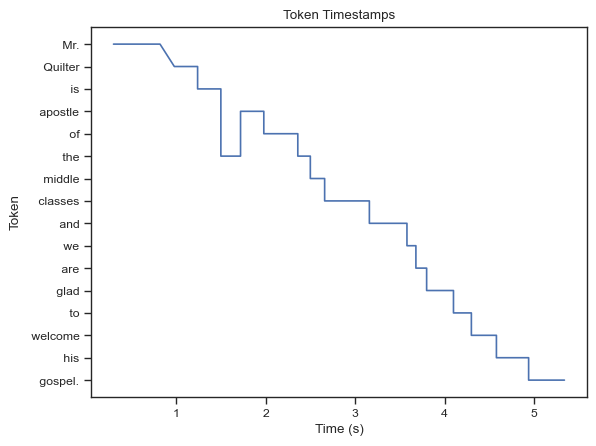

In [11]:
# Plot the token timestamps
timestamps = []
tokens = []
for segment in result["segments"]:
    for word in segment["words"]:
        timestamps.append(word["start"])
        timestamps.append(word["end"])
        tokens.append(word["word"])
        tokens.append(word["word"])
plt.plot(timestamps[::-1], tokens[::-1])
plt.xlabel("Time (s)")
plt.ylabel("Token")
plt.title("Token Timestamps")
plt.show()